# SVRG и Катюша становятся лучше без внешнего цикла

## Постановка задачи

Рассмотрим задачу вида конечной суммы:

$$ f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x) \rightarrow \min_{x \in \mathbb{R}^d} \quad (1) $$

Такую задачу приходится решать в машинном обучении с учителем (минимизация эмпирического риска). В таком контексте $n$ &mdash; это размер обучающей выборки, $x$ &mdash; вектор из $d$ параметров модели, а $f_i(x)$ &mdash; значение функции потерь на $i$-м объекте выборки при параметрах $x$.

Для решения таких задач используются методы редукции дисперсии, такие как SAGA, SVRG, Katyusha.

**Алгоритм SVRG.** (Для упрощения восприятия не будем писать индексы $x^k$, $w^k$ и пр., понимая знак равенства как оператор присваивания)

**Вход:** размер шага $\eta > 0$, количество итераций внутреннего цикла $m$, стартовая точка $x \in \mathbb{R}^d$, количество итераций $K$.

**for** $k = 0, 1, 2, \dots, K-1$ **do**: <br>
&nbsp; &nbsp; $w = x$ <br>
&nbsp; &nbsp; **for** $t = 0, 1, 2, \dots, m - 1$ **do**: <br>
&nbsp; &nbsp; &nbsp; &nbsp; Выбрать $i$ случайно, равновероятно из $\{1, \dots, n\}$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; $g = \nabla f_i(x) - \nabla f_i(w) + \nabla f(w)$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; $x = x - \eta g$ <br>
&nbsp; &nbsp; **end for** <br>
**end for**

**Выход:** $x_K$.

Этот алгоритм, как и SGD, использует вместо градиента его несмещённую оценку, но в отличие от SGD эта оценка подправляется с использованием значения градиента в контрольной точке $w$.

В классическом SVRG градиент в контрольной точке подсчитывается во внешнем цикле, то есть через каждые $m$ итераций. Идея loopless версий подобных алгоритмов состоит в том, чтобы убрать внешний цикл: пусть вместо этого на каждой итерации контрольная точка может обновиться с вероятностью $p$:

**Алгоритм Loopless SVRG (L-SVRG)**

**Вход:** размер шага $\eta > 0$, вероятность $p \in (0, 1]$, стартовая точка $x^0 \in \mathbb{R}^d$, количество итераций $K$.

$w^0 = x^0$ <br>
**for** $k = 0, 1, 2, \dots, K-1$ **do**: <br>
&nbsp; &nbsp; Выбрать $i$ случайно, равновероятно из $\{1, \dots, n\}$ <br>
&nbsp; &nbsp; $g^k = \nabla f_i(x^k) - \nabla f_i(w^k) + \nabla f(w^k)$ <br>
&nbsp; &nbsp; $x^{k+1} = x^k - \eta g^k$ <br>
&nbsp; &nbsp; $w^{k+1} = \cases{x^k \ \ \text{с вероятностью } p\\w^k \ \text{с вероятностью } 1-p}$ <br>
**end for**

**Выход:** $x_K$.

Можно также интерпретировать это так: длина внутреннего цикла становится случайной.

Кроме loopless версии SVRG, в статье рассматривается Loopless Katyusha:

**Алгоритм Loopless Katyusha (L-Katyusha)**

**Вход:** $\theta_1$, $\theta_2$, вероятность $p \in (0, 1]$, стартовая точка $y^0 \in \mathbb{R}^d$, количество итераций $K$.

$\displaystyle \eta = \frac{\theta_2}{(1 + \theta_2)\theta_1}$ <br>
$\displaystyle \sigma = \frac{\mu}{L}$ ($\mu, L$ &mdash; константа сильной выпуклости и константа Липшица градиента соответственно) <br>
$w^0 = z^0 = y^0$ <br>
**for** $k = 0, 1, 2, \dots, K-1$ **do**: <br>
&nbsp; &nbsp; $x^k = \theta_1 z^k + \theta_2 w^k + (1 - \theta_1 - \theta_2) y^k$ <br>
&nbsp; &nbsp; Выбрать $i$ случайно, равновероятно из $\{1, \dots, n\}$ <br>
&nbsp; &nbsp; $g^k = \nabla f_i(x^k) - \nabla f_i(w^k) + \nabla f(w^k)$ <br>
&nbsp; &nbsp; $z^{k+1} = \frac{1}{1 + \eta \sigma}\left( \eta \sigma x^k + z^k - \frac{\eta}{L} g^k \right)$ <br>
&nbsp; &nbsp; $y^{k+1} = x^k + \theta_1 (z^{k+1} - z^k)$ <br>
&nbsp; &nbsp; $w^{k+1} = \cases{y^k \ \ \text{с вероятностью } p\\w^k \ \text{с вероятностью } 1-p}$ <br>
**end for**

**Выход:** $y_K$.

Классический алгоритм Katyusha отличается от приведённого только тем, что контрольная точка обновляется во внешнем цикле. 

## Преимущества предложенных методов

- Теоретические оценки на сходимость остаются такими же, как у loopy версий

- Для сходимости L-SVRG подходит большой диапазон вероятностей $p$, включая $\frac{1}{n}$

- На практике loopless версии часто сходятся быстрее, даже при не оптимальных параметрах

## Скорость сходимости

### L-SVRG

Пусть $\displaystyle \eta = \frac{1}{6 L}, p = \frac{1}{n}$. Тогда $\displaystyle \mathbb{E}(\Phi^k) \leq \varepsilon \Phi^0$ при $\displaystyle k \geq O\left(\left(n + \frac{L}{μ}\right) \log\frac{1}{\varepsilon}\right)$, <br>
где $\displaystyle \Phi^k = \| x^k - x^* \|^2 + \frac{4 \eta^2}{p n} \sum_{i=1}^n \left\| \nabla f_i(w^k) - \nabla f_i(x^*) \right\|^2$.

### L-Katyusha

Пусть $\displaystyle \theta_1 = \min\left\{\sqrt{\frac{2\sigma n}{3}}, \frac{1}{2}\right\}, \theta_2 = \frac{1}{2}, p = \frac{1}{n}$. Тогда $\mathbb{E}(\Psi^k) \leq \varepsilon \Psi^0$ при $\displaystyle k \geq O\left(\left(n + \sqrt{\frac{n L}{μ}}\right) \log\frac{1}{\varepsilon}\right)$, <br>
где $\displaystyle \Phi^k = \frac{L (1 + \eta \sigma)}{2 \eta} \| z^k - x^* \|^2 + \frac{1}{\theta_1}(f(y^k) - f(x^*)) + \frac{\theta_2 (1 + \theta_1)}{p \theta_1}(f(w^k) - f(x^*))$.

$\left(\displaystyle \eta = \frac{\theta_2}{(1 + \theta_2)\theta_1}, \ \sigma = \frac{\mu}{L}\right)$

## Реализация методов

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.datasets import load_svmlight_file

In [2]:
def SVRG(n, grad, outer_num_iter, x_0, stepsize, m, rng):
    x = x_0.copy()
    xs = [x.copy()]

    for k in tqdm(range(outer_num_iter)):
        # нам не нужно хранить w, только градиент в ней
        grads_w = np.array([grad(i, x) for i in range(n)])
        grad_w = grads_w.mean()

        for t in range(m):
            i = rng.integers(n)
            g = grad(i, x) - grads_w[i] + grad_w
            x -= stepsize * g
            xs.append(x.copy())

    return np.array(xs)

In [3]:
def L_SVRG(n, grad, num_iter, x_0, stepsize, p, rng):
    x = x_0.copy()
    xs = [x.copy()]

    grads_w = np.array([grad(i, x) for i in range(n)])
    grad_w = grads_w.mean()

    for k in tqdm(range(num_iter)):
        i = rng.integers(n)
        g = grad(i, x) - grads_w[i] + grad_w

        if rng.binomial(n=1, p=p):
            grads_w = np.array([grad(i, x) for i in range(n)])
            grad_w = grads_w.mean()

        x -= stepsize * g
        xs.append(x.copy())

    return np.array(xs)

In [4]:
def Katyusha(n, grad, outer_num_iter, y_0, t1, t2, m, mu, L, rng):
    eta = t2 / (1 + t2) / t1
    sigma = mu / L

    y = y_0.copy()
    ys = [y.copy()]
    z = y.copy()
    
    for k in tqdm(range(outer_num_iter)):
        w = y.copy()
        grads_w = np.array([grad(i, w) for i in range(n)])
        grad_w = grads_w.mean()
        
        for t in range(m):
            x = t1 * z + t2 * w + (1 - t1 - t2) * y

            i = rng.integers(n)
            g = grad(i, x) - grads_w[i] + grad_w

            new_z = (eta * sigma * x + z - eta / L * g) / (1 + eta * sigma)
            y = x + t1 * (new_z - z)
            ys.append(y.copy())
            z = new_z.copy()

    return np.array(ys)

In [5]:
def L_Katyusha(n, grad, num_iter, y_0, t1, t2, p, mu, L, rng):
    eta = t2 / (1 + t2) / t1
    sigma = mu / L

    y = y_0.copy()
    ys = [y.copy()]
    z = y.copy()

    w = y.copy()
    grads_w = np.array([grad(i, w) for i in range(n)])
    grad_w = grads_w.mean()

    for k in tqdm(range(num_iter)):
        x = t1 * z + t2 * w + (1 - t1 - t2) * y

        i = rng.integers(n)
        g = grad(i, x) - grads_w[i] + grad_w

        if rng.binomial(n=1, p=p):
            w = y.copy()
            grads_w = np.array([grad(i, w) for i in range(n)])
            grad_w = grads_w.mean()

        new_z = (eta * sigma * x + z - eta / L * g) / (1 + eta * sigma)
        y = x + t1 * (new_z - z)
        ys.append(y.copy())
        z = new_z.copy()

    return np.array(ys)

## Численные эксперименты

### Игрушечный пример

Начнём с простой функции, чтобы убедиться, что код работает.

Пусть $n = d$, $f_i(x) = \frac{i}{2} x_i^2,\ i=1,\dots,n$. <br>
$\nabla f_i(x) = i x_i e_i$

Константы сильной выпуклости и липшицевости градиента для $i$-ой функции: $\mu_i=i,\ L_i=i$. <br>
Значит, все функции являются $\mu$-сильно выпуклыми и $L$-гладкими для  $\mu=1,\ L=n$.

In [6]:
def f_toy(i, x):
    return x[i]**2 * (i + 1) / 2


def grad_toy(i, x):
    res = np.zeros_like(x)
    res[i] = (i + 1) * x[i]
    return res

In [7]:
d = 20
n = d

L = n
mu = 1
t1 = (2 * mu * n / 3 / L) ** .5
if t1 > 0.5:
    t1 = 0.5

In [8]:
rng = np.random.default_rng(3194312162)

init = 5 * np.ones(d)
num_iter = 1500
xs_1 = L_SVRG(n, grad_toy, num_iter, init, stepsize=1/(6 * L), p=1/n, rng=rng)
xs_2 = L_SVRG(n, grad_toy, num_iter, init, stepsize=1/(6 * L), p=2/n, rng=rng)
xs_3 = L_SVRG(n, grad_toy, num_iter, init, stepsize=1/(6 * L), p=3/n, rng=rng)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

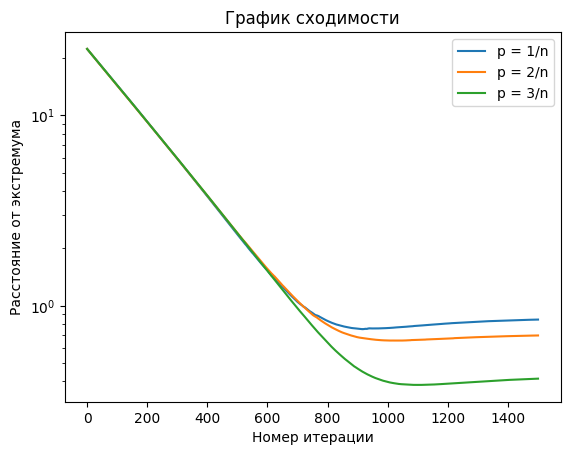

In [9]:
plt.plot(np.linalg.norm(xs_1, axis=1), label='p = 1/n')
plt.plot(np.linalg.norm(xs_2, axis=1), label='p = 2/n')
plt.plot(np.linalg.norm(xs_3, axis=1), label='p = 3/n')
plt.yscale('log')
plt.title('График сходимости')
plt.xlabel('Номер итерации')
plt.ylabel('Расстояние от экстремума')
plt.legend()
plt.show()

In [10]:
rng = np.random.default_rng(3194312162)

init = 5 * np.ones(d)
num_iter = 800
xs_s = SVRG(n, grad_toy, num_iter//n, init, stepsize=1/(6 * L), m=n, rng=rng)
xs_ls = L_SVRG(n, grad_toy, num_iter, init, stepsize=1/(6 * L), p=1/n, rng=rng)
xs_k = Katyusha(n, grad_toy, num_iter//n, init, t1=t1, t2=0.5, m=n, mu=mu, L=L, rng=rng)
xs_lk = L_Katyusha(n, grad_toy, num_iter, init, t1=t1, t2=0.5, p=1/n, mu=1, L=L, rng=rng)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

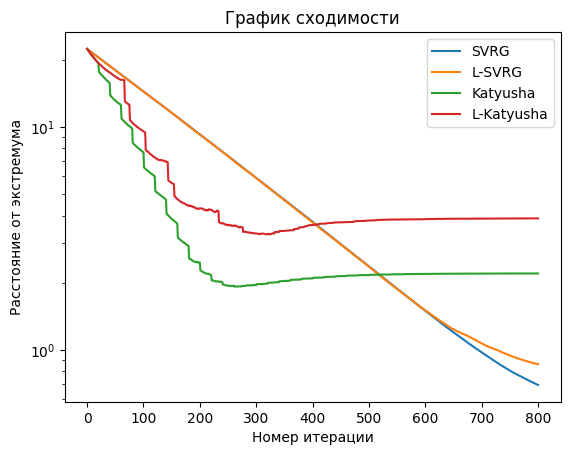

In [11]:
plt.plot(np.linalg.norm(xs_s, axis=1), label='SVRG')
plt.plot(np.linalg.norm(xs_ls, axis=1), label='L-SVRG')
plt.plot(np.linalg.norm(xs_k, axis=1), label='Katyusha')
plt.plot(np.linalg.norm(xs_lk, axis=1), label='L-Katyusha')
plt.yscale('log')
plt.title('График сходимости')
plt.xlabel('Номер итерации')
plt.ylabel('Расстояние от экстремума')
plt.legend()
plt.show()

In [12]:
def fs(n, f_i, xs):
    return np.array([sum(f_i(i, x) for i in range(n)) / n for x in xs])

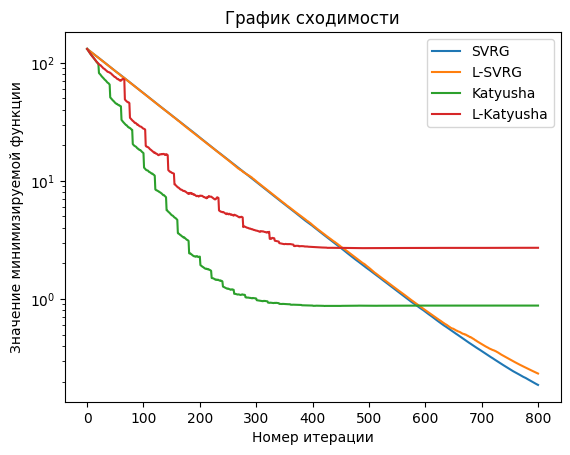

In [13]:
plt.plot(fs(n, f_toy, xs_s), label='SVRG')
plt.plot(fs(n, f_toy, xs_ls), label='L-SVRG')
plt.plot(fs(n, f_toy, xs_k), label='Katyusha')
plt.plot(fs(n, f_toy, xs_lk), label='L-Katyusha')
plt.yscale('log')
plt.title('График сходимости')
plt.xlabel('Номер итерации')
plt.ylabel('Значение минимизируемой функции')
plt.legend()
plt.show()

**Реальные данные:** логистическая регрессия для датасета "mushrooms"

$\displaystyle f_i(x) = \ln(1 + \exp(-b_i a_i^T x)) + \frac{\mu}{2} \| x \|^2 $, где $b_i \in \{ -1, +1\}$, $a_i \in \mathbb{R}^d, i \in [n]$

$\displaystyle f(x) = \frac{1}{n}\sum_{i=1}^n f_i(x) = \frac{1}{n}\sum_{i=1}^n \ln(1 + \exp(-b_i a_i^T x)) + \frac{\mu}{2} \| x \|^2$

Тогда $\mu$ &mdash; констанста сильной выпуклости $f$

$\displaystyle L = \frac{1}{4n}\sum\limits_{i=1}^n \|a_i \|^2 + \mu$

$\displaystyle \nabla f_i(x) = \frac{-b_i a_i}{1 + \exp(b_i x^T a_i)} + \mu x$

In [14]:
A, b = load_svmlight_file('mushrooms.txt')
A = A.toarray()  # from sparse matrix to numpy ndarray
b = 2 * b - 3    # from "1 or 2" to "-1 or 1"
n, d = A.shape
n, d

(8124, 112)

In [15]:
def f_mush(i, x):
    return np.log(1 + np.exp(- b[i] * np.dot(A[i], x))) + np.sum(x ** 2) * mu / 2


def grad_mush(i, x):
    return - b[i] / np.log(1 + np.exp(b[i] * np.dot(A[i], x))) * A[i] + mu * x

In [16]:
mu = 1
L = np.sum(A ** 2) / 4 / n + mu
t1 = (2 * mu * n / 3 / L) ** .5
if t1 > 0.5:
    t1 = 0.5

In [17]:
rng = np.random.default_rng(1216231943)

init = np.zeros_like(A[0])
num_iter = n * 8
xs_s = SVRG(n, grad_mush, num_iter//n, init, stepsize=1/(6 * L), m=n, rng=rng)
xs_ls = L_SVRG(n, grad_mush, num_iter, init, stepsize=1/(6 * L), p=1/n, rng=rng)
xs_k = Katyusha(n, grad_mush, num_iter//n, init, t1=t1, t2=0.5, m=n, mu=mu, L=L, rng=rng)
xs_lk = L_Katyusha(n, grad_mush, num_iter, init, t1=t1, t2=0.5, p=1/n, mu=mu, L=L, rng=rng)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/64992 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/64992 [00:00<?, ?it/s]

In [18]:
f = lambda x: sum(f_mush(i, x) for i in range(n)) / n
print('SVRG:', f(xs_s[-1]))
print('L-SVRG:', f(xs_ls[-1]))
print('Katyusha:', f(xs_k[-1]))
print('L-Katyusha:', f(xs_lk[-1]))

SVRG: 0.6969241214933075
L-SVRG: 0.6939479825063481
Katyusha: 0.6928535700986805
L-Katyusha: 0.6933204908843146


In [19]:
x_opt = Katyusha(n, grad_mush, num_iter//n, y_0=xs_k[-1], t1=t1, t2=0.5, m=n, mu=mu, L=L, rng=rng)[-1]

  0%|          | 0/8 [00:00<?, ?it/s]

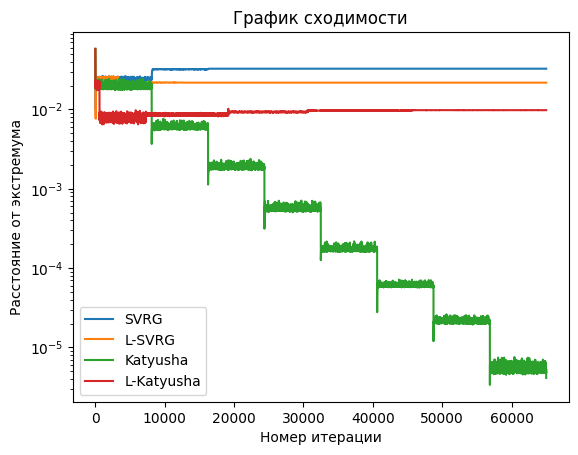

In [20]:
plt.plot(np.linalg.norm(x_opt - xs_s, axis=1), label='SVRG')
plt.plot(np.linalg.norm(x_opt - xs_ls, axis=1), label='L-SVRG')
plt.plot(np.linalg.norm(x_opt - xs_k, axis=1), label='Katyusha')
plt.plot(np.linalg.norm(x_opt - xs_lk, axis=1), label='L-Katyusha')
plt.yscale('log')
plt.title('График сходимости')
plt.xlabel('Номер итерации')
plt.ylabel('Расстояние от экстремума')
plt.legend()
plt.show()

---